In [1]:
%load_ext autoreload
%autoreload

In [2]:
import math

import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda')

In [4]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/generate_cow_renders.py
from plot_image_grid import image_grid
from generate_cow_renders import generate_cow_renders

--2022-03-04 18:31:26--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py.17’

plot_image_grid.py. 100%[===================>]   1.57K  --.-KB/s    in 0s      

2022-03-04 18:31:26 (25.5 MB/s) - ‘plot_image_grid.py.17’ saved [1608/1608]

--2022-03-04 18:31:26--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/generate_cow_renders.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP requ

In [5]:
_, cow_images, _ = generate_cow_renders()

/home/brett/miniconda3/envs/geometry/lib/python3.9/site-packages/pytorch3d/transforms/transform3d.py:780: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


In [6]:
from kaigeo import datasets, nerf_models, gan_models, pulsar_gan_models

In [7]:
ls = pulsar_gan_models.PulsarGanModel(device, 64, 64).to(device)
opt_ls = torch.optim.Adam(ls.parameters(), lr=0.001)#, weight_decay=1e-5)

In [8]:
from torchgan.models import DCGANDiscriminator, DCGANGenerator

In [9]:
session2 = datasets.load_session2()
session1 = datasets.load_session1()

In [10]:
target_images = cow_images[:, ::2, ::2].to(device)# torch.concat([session1.target_images, session2.target_images]).to(device)[:, ::2, ::2][1:]

In [11]:
d = DCGANDiscriminator(in_size=64, last_nonlinearity=nn.Sigmoid()).to(device) #Discriminator().to(device)
opt_d = torch.optim.Adam(d.parameters(), lr=0.001)

In [12]:
##g = DCGANGenerator().to(device)

In [13]:
#g

In [14]:
def plot3d(m):    
    z = torch.randn((1, 30), device=device)

    
    p = ls.get_points(z).squeeze().detach().cpu().numpy()
    print(p.shape)


    c = ls.latent_col(z).reshape(1, -1, 3).squeeze().detach().cpu().numpy()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection="3d")
    ax.view_init(vertical_axis="y")

    ax.scatter(p[:, 0], p[:, 1], p[:, 2], alpha=0.5, c=c)

(100000, 3)


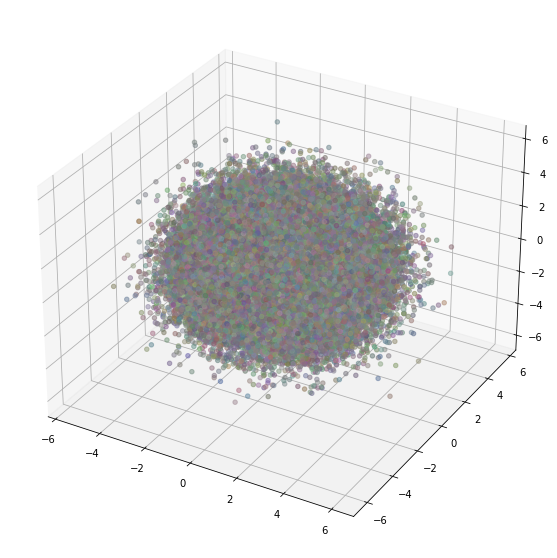

In [15]:
plot3d(ls)

In [16]:
#ls.latent_pos.requires_grad= False
for i in range(19):
    target_pts = torch.randn((10, ls.n_objects*3), device=device) * 20.0

    for i in range(100):
        opt_ls.zero_grad()

        z = torch.randn((10, 30), device=device)
        loss = torch.nn.functional.mse_loss(
                ls.object_centers(z).reshape(10, -1), target_pts)
        loss.backward()
        opt_ls.step()
        
print(loss)
#ls.latent_pos.requires_grad= True

tensor(366.8976, device='cuda:0', grad_fn=<MseLossBackward0>)


(100000, 3)


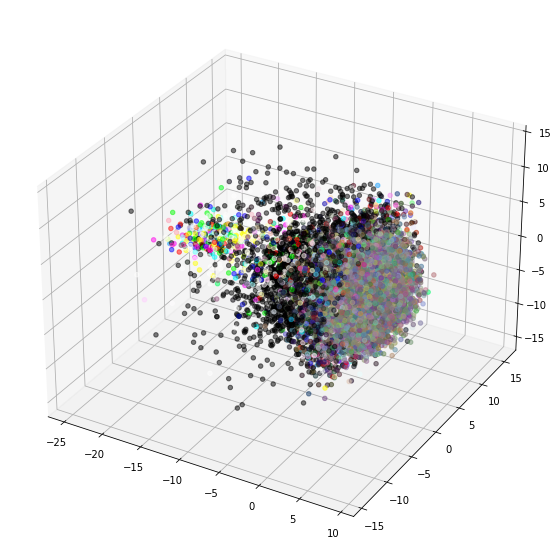

In [231]:
plot3d(ls)

In [18]:
(rendered, cam_params),  cameras, zs = ls.generate(1, random_cameras=True, random_zs=False)

In [19]:
def generate(n):
    (rendered, cam_params),  cameras, zs = ls.generate(n, random_cameras=True, random_zs=True)
    
    return rendered

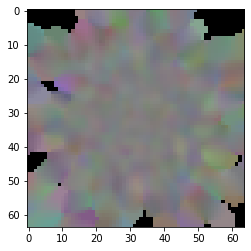

In [20]:
plt.imshow(rendered[0].detach().cpu().numpy())

In [21]:
def descriminator_step():
    opt_d.zero_grad()

    loss = 0
    ri = torch.randint(len(target_images), size=(5,))
    #ri = [1, 2]
    Y = torch.full((5,), 1.0, dtype=torch.float, device=device)            
    y = d(target_images[ri].permute(0, 3, 1, 2))
    loss += torch.nn.functional.binary_cross_entropy(y, Y)
    
    rendered = generate(5)
    Y = torch.full((5,), 0.0, dtype=torch.float, device=device)
    y = d(rendered.permute(0, 3, 1, 2))
    loss += torch.nn.functional.binary_cross_entropy(y, Y)

    loss.backward()
    opt_d.step()

    return loss

In [22]:
def generator_step():
    opt_ls.zero_grad()
    rendered = generate(5)
    Y = torch.full((5,), 1.0, dtype=torch.float, device=device)
    y  = d(rendered.permute(0, 3, 1, 2))
    #mean_density = torch.mean(density)
    loss = torch.nn.functional.binary_cross_entropy(y, Y) #- 3.0*mean_density

    loss.backward()    
    opt_ls.step()

    return loss, rendered

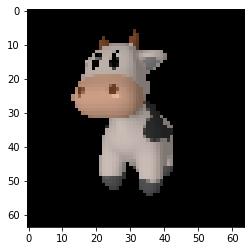

In [23]:
plt.imshow(target_images[22].detach().cpu().numpy())

In [214]:
for i in range(3000):
    for _ in range(1):
        d_loss = descriminator_step()    
    
    for _ in range(5):
        g_loss, rendered = generator_step()
    
    if i % 10 == 0:
        print('d', d_loss)
        print('ls', g_loss)
        #print('density', mean_density)


d tensor(9.5367e-08, device='cuda:0', grad_fn=<AddBackward0>)
ls tensor(25.7620, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
d tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
ls tensor(17.2288, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
d tensor(1.0848e-06, device='cuda:0', grad_fn=<AddBackward0>)
ls tensor(22.9992, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
d tensor(7.0334e-06, device='cuda:0', grad_fn=<AddBackward0>)
ls tensor(19.1486, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
d tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
ls tensor(26.0374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
d tensor(0.0064, device='cuda:0', grad_fn=<AddBackward0>)
ls tensor(27.9355, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
d tensor(0.0058, device='cuda:0', grad_fn=<AddBackward0>)
ls tensor(30.4389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
d tensor(4.2179e-05, device='cuda:0', grad_fn=<AddBackwar

KeyboardInterrupt: 

In [233]:
plt.imshow(generate(1)[0].detach().cpu())

SyntaxError: invalid syntax (56629628.py, line 1)

In [228]:
ls.bg_color

Parameter containing:
tensor([0., 0., 0.], device='cuda:0', requires_grad=True)

In [207]:
plt.imshow(ls.generate(1)[0].detach().cpu())

AttributeError: 'tuple' object has no attribute 'detach'

In [ ]:
torch.min(generate_images()[1].detach().cpu()[0])t

In [ ]:
R, T = look_at_view_transform(
    eye = torch.tensor([[0.9, s0.0, 0.0]]), 
    at = torch.tensor([[0.0, 0.0, 0.0]])
)

target_cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

rendered, _ = renderer_grid(target_cameras, ls.random_gen)
rendered = rendered[:, :, :, 1:4]
Y = torch.full((1,), 1.0, dtype=torch.float, device=device)
y = d(rendered.permute(0, 3, 1, 2)).view(-1)
plt.imshow(rendered.detach().cpu()[0])

In [ ]:
opt.zero_grad()
res, _ = renderer_grid(target_cameras, volumetric_function)
loss = torch.nn.functional.mse_loss(res[0][:, :, 1:4], target_image)
loss.backward()
opt.step()

In [ ]:
def plot3d(m):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection="3d")
    ax.view_init(vertical_axis="y")
    indices = m.latent_pos)
    print(len(indices))
    p = m.geometry_model.pos[indices].detach().cpu().numpy()
    c = torch.sigmoid(m.geometry_model.col[indices]).detach().cpu().numpy()
    ax.scatter(p[:, 0], p[:, 1], p[:, 2], alpha=0.5, c=c)


